# OSM Lab Computation, Week 3
### Rebekah Dix

In [1]:
import numpy as np
from scipy import linalg as la
import matplotlib.pyplot as plt
from scipy import sparse
import pandas as pd
from numba import vectorize, jit, njit, float64, prange
import quantecon as qe
import sympy as sy
import math

# The QR Decomposition

### Problem 1

In [2]:
def reduced_QR(A):
    
    m, n = np.shape(A)
    Q = np.copy(A)
    R = np.zeros((n, n))
    
    for ii in range(n):
        R[ii, ii] = la.norm(Q[:,ii])
        Q[:, ii] = Q[:, ii] / R[ii, ii]
        
        for jj in range(ii+1, n):
            R[ii, jj] = Q[:, jj] @ Q[:, ii]
            Q[:, jj] = Q[:, jj] - R[ii, jj] * Q[:, ii]
    
    return Q, R

In [3]:
A = np.random.random((4,4))
Q1, R1 = reduced_QR(A)
print(np.allclose(np.triu(R1), R1))
print(np.allclose(Q1.T @ Q1, np.identity(4)))
print(np.allclose(Q1 @ R1, A))

True
True
True


### Problem 2

In [4]:
def determinant_QR(A):
    return np.prod(np.diag(reduced_QR(A)[1]))

In [5]:
detA = determinant_QR(A)
error = la.det(A) - detA
error

1.3633842319005218e-17

### Problem 3

In [6]:
def solve_system_QR(A, b):
    Q, R = reduced_QR(A)
    m, n = np.shape(A)
    y = Q.T @ b
    
    x = np.zeros(n)
    
    for kk in range(n-1, -1, -1):
        x[kk] = (1 / R[kk,kk]) * (y[kk] - (R[kk, kk+1:] @ x[kk+1:]))
    return x                           

In [7]:
A = np.random.random((4,4))
b = np.array([9,8,7,6])
x1 = np.linalg.solve(A, b)
x = solve_system_QR(A, b)

print(np.allclose(np.dot(A, x), b))
print(np.allclose(x, x1))

True
True


### Problem 4

In [8]:
def householder(A):
    m, n = np.shape(A)
    R = np.copy(A)
    Q = np.identity(m)
    
    sign = lambda x: 1 if x >= 0 else -1
    
    for kk in range(n):
        u = np.copy(R[kk:, kk])
        u[0] = u[0] + sign(u[0]) * la.norm(u)
        u = u / la.norm(u)
        R[kk:, kk:] = R[kk:, kk:] - 2 * (np.outer(u, np.dot(u.T, R[kk:, kk:])))
        Q[kk:, :] = Q[kk:, :] - 2 * (np.outer(u, np.dot(u.T, Q[kk:, :])))
    return Q.T, R

In [9]:
A = np.random.random((5, 3))
Q, R = householder(A)
print(np.allclose(Q @ R, A))
print(np.allclose(Q.T @ Q, np.identity(5)))
print(np.allclose(np.triu(R), R))

True
True
True


### Problem 5

In [10]:
def hessenberg(A):
    m, n = np.shape(A)
    H = np.copy(A)
    Q = np.identity(m)
    
    sign = lambda x: 1 if x >= 0 else -1
    
    for kk in range(n-2):
        u = np.copy(H[kk+1:, kk])
        u[0] = u[0] + sign(u[0]) * la.norm(u)
        u = u / la.norm(u)
        
        H[kk+1:, kk:] = H[kk+1:, kk:] - 2 * (np.outer(u, np.dot(u.T, H[kk+1:, kk:])))
        H[:, kk+1:] = H[:, kk+1:] - 2 * (np.outer(np.dot(H[:, kk+1:], u),  u.T))
        Q[kk+1:, :] = Q[kk+1:, :] - 2 * (np.outer(u, np.dot(u.T, Q[kk+1:, :])))
        
    return H, Q.T

In [11]:
A = np.random.random((8,8))
H, Q = hessenberg(A)
print(np.allclose(np.triu(H, -1), H))
print(np.allclose(Q @ H @ Q.T, A))

True
True


# Least Squares and Computing Eigenvalues

### Problem 1

In [12]:
def solve_system_normal(A, b):
        
    Q, R = la.qr(A, mode='economic')
    x = la.solve_triangular(R, np.dot(Q.T, b))
    
    return x

In [13]:
A = np.random.random((5,3))
b = np.random.random(5)
x = solve_system_normal(A, b)
print(np.allclose(A.T @ A @ x, A.T @ b))

True


### Problem 2

In [14]:
housing = np.load('housing.npy')

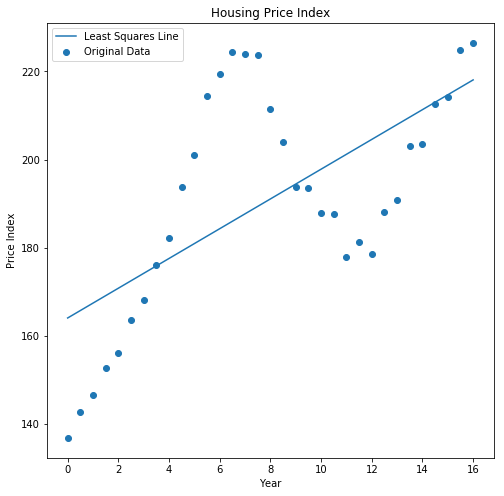

In [15]:
n = len(housing)
A = np.column_stack((housing[:,0], np.ones(n)))
b = housing[:,1]
x = solve_system_normal(A, b)

fig, ax = plt.subplots(figsize=(8,8))
plt.scatter(housing[:,0], b, label='Original Data')
plt.xlabel('Year')
plt.ylabel('Price Index')
plt.title('Housing Price Index')
plt.plot(housing[:,0], A @ x, label='Least Squares Line')
plt.legend()
plt.show()

### Problem 3

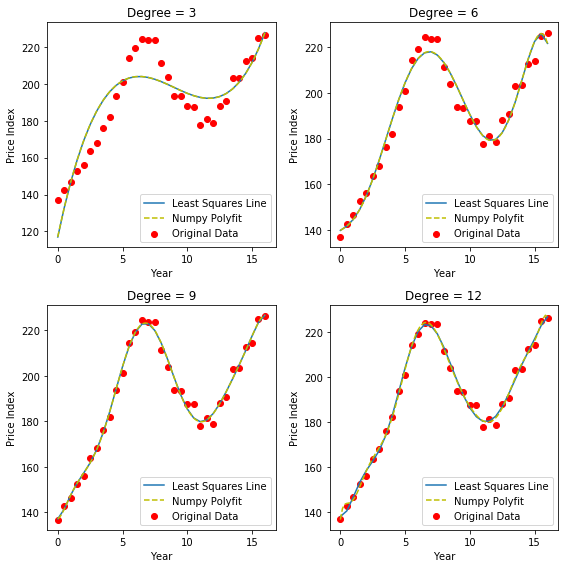

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(8,8))
n = len(housing)
degarray = np.array([3, 6, 9, 12])
domain = np.linspace(0, 16, 100)
for count, deg in enumerate(degarray):
    A = np.zeros((n, deg+1))
    for ii in range(deg, -1, -1):
        A[:,ii] = housing[:,0] ** ii
    b = housing[:,1]
    x = la.lstsq(A, b)[0]
    
    compare = np.polyfit(housing[:,0], housing[:,1], deg)
    f = np.poly1d(compare)
    
    plt.subplot(2, 2, count + 1)
    plt.scatter(housing[:,0], b, c='red', label='Original Data')
    plt.plot(housing[:,0], A @ x, label='Least Squares Line')
    plt.plot(domain, f(domain), 'y--', label='Numpy Polyfit')
    
    plt.xlabel('Year')
    plt.ylabel('Price Index')
    plt.title(r'Degree = %i' %deg)
    plt.legend()
    
plt.tight_layout()
plt.show() 


### Problem 4

In [17]:
ellipse = np.load('ellipse.npy')

In [18]:
n = len(ellipse)
x = ellipse[:, 0]
y = ellipse[:, 1]
A = np.column_stack((x ** 2, x, x * y, y, y ** 2))
b = np.ones(n)
a, b, c, d, e= la.lstsq(A, b)[0]

In [19]:
def plot_ellipse(a, b, c, d, e):
    """Plot an ellipse of the form ax^2 + bx + cxy + dy + ey^2 = 1."""
    theta = np.linspace(0, 2*np.pi, 200)
    cos_t, sin_t = np.cos(theta), np.sin(theta)
    A = a*(cos_t**2) + c*cos_t*sin_t + e*(sin_t**2)
    B = b*cos_t + d*sin_t
    r = (-B + np.sqrt(B**2 + 4*A)) / (2*A)
    plt.plot(r*cos_t, r*sin_t, lw=2, label='Least Squares')
    plt.gca().set_aspect("equal", "datalim")

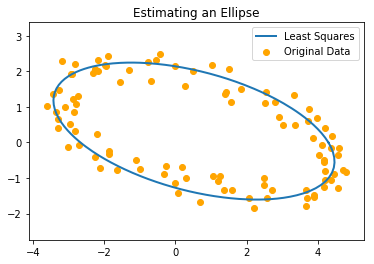

In [20]:
plot_ellipse(a, b, c, d, e)
plt.scatter(x, y, c='orange', label='Original Data')
plt.title('Estimating an Ellipse')
plt.legend()
plt.show()

### Problem 5

In [21]:
def dominant_eigen_iter(A, N, tol):
    m, n = np.shape(A) 
    xinit = np.random.rand(n)
    xinit = xinit/la.norm(xinit)
    
    xk = xinit
    currIt = 1
    eps = tol + 1
    
    while (currIt < N and eps > tol):
        xknew = np.dot(A, xk)
        xknew = xknew / la.norm(xknew)
        eps = np.linalg.norm(xknew - xk)
        xk = xknew
        currIt += 1
    return np.dot(xk.T, np.dot(A, xk)), xk

In [22]:
A = np.random.random((3,3))
eigs, vecs = la.eig(A)
loc = np.argmax(eigs)
lamb, x = eigs[loc], vecs[:,loc]
lamb1, x1 = dominant_eigen_iter(A, 100, 1e-12)

In [23]:
lamb

(1.7486470072555784+0j)

In [24]:
lamb1

1.748647007255598

In [25]:
np.allclose(A @ x1, lamb1 * x1)

True

### Problem 6

In [26]:
def QR_full(A, N, tol):
    m, n = np.shape(A) 
    S = la.hessenberg(A)
    
    for kk in range(N):
        Q, R = la.qr(S, mode='economic')
        S = R @ Q
        
    eigs = []
    ii = 0
    
    while ii < n:  
        if ii == n-1:
            eigs.append(S[ii,ii])
        elif np.abs(S[ii+1, ii]) < tol:
            eigs.append(S[ii,ii])
        else:
            a = 1
            b = -(S[ii,ii] + S[ii+1, ii+1])
            c = (S[ii,ii] * S[ii+1, ii+1] - S[ii, ii+1] * S[ii+1, ii])
            eig1 = (-b + cmat.sqrt(b ** 2 - 4*a*c)) / (2*a)
            eig2 = (-b - cmat.sqrt(b ** 2 - 4*a*c)) / (2*a)
            eigs.append(eig1, eig2)
            ii = ii + 1
        ii = ii + 1
    
    return eigs

In [27]:
A = np.random.random((3,3))
A = A + A.T
eigs, vecs = la.eig(A)
eigs1 = QR_full(A, 1000, 1e-12)

In [28]:
eigs

array([ 3.66618357+0.j, -0.80236237+0.j,  0.82879223+0.j])

In [29]:
eigs1

[3.666183574732954, 0.8287922326832228, -0.802362365834703]

# The SVD and Image Compression

In [30]:
def compact_SVD(A, tol):
    m, n = np.shape(A) 
    eigs, vecs = la.eig(np.dot(A.conj().T, A))
    singVals = np.sqrt(eigs)
    
    order = np.argsort(singVals)[::-1]
    singVals = singVals[order]
    vecs = vecs[order]
        
    r = sum(1 for val in singVals if val > tol)
    indPos = np.where(singVals > 0)
    singVals = singVals[indPos]
    vecs = vecs[indPos]

    U = np.empty((m,r), dtype=np.complex64)
    
    for ii in range(r):
        U[:, ii] = np.dot(A, vecs[:,ii]) / singVals[ii]
    
    return U, singVals, vecs.conj().T

In [31]:
A = np.random.random((10,5))
U, s, Vh = la.svd(A, full_matrices=False)
U1, s1, Vh1 = compact_SVD(A, 1e-12)

In [32]:
s

array([3.58905783, 1.1126229 , 1.01251959, 0.72774989, 0.57383843])

In [33]:
s1

array([3.58905783+0.j, 1.1126229 +0.j, 1.01251959+0.j, 0.72774989+0.j,
       0.57383843+0.j])

In [34]:
#print(np.allclose(U1.T @ U1, np.identity(len(s1))))
print(np.allclose(U1 @ np.diag(s1) @ Vh1, A))
print(np.linalg.matrix_rank(A) == len(s1))
print(np.allclose(Vh1 @ Vh1.conj().T, np.identity(len(s1))))

True
True
True


### Problem 2

In [35]:
def problem_2_SVD(A):
    S = np.empty((2, 200))
    theta = np.linspace(0, 2*np.pi, 200)
    S[0, :] = np.cos(theta)
    S[1, :] = np.sin(theta)
    E = np.array([[1, 0, 0], [0, 0, 1]])
    
    U, s, Vh = la.svd(A)
    
    fig, ax = plt.subplots(2, 2, figsize=(8,8))
    ax[0,0].plot(S[0, :], S[1, :], '-', lw=1) 
    ax[0,0].plot(E[0,:], E[1,:], 'orange') 
    ax[0,0].axis("equal")
    ax[0,0].set_title(r'$S$')
    
    ax[0,1].plot(np.dot(Vh, S)[0, :], np.dot(Vh, S)[1, :], '-', lw=1)
    ax[0,1].plot(np.dot(Vh, E)[0, :], np.dot(Vh, E)[1, :], 'orange')
    ax[0,1].axis("equal")
    ax[0,1].set_title(r'$V^HS$')
    
    ax[1,0].plot((np.diag(s) @ Vh @ S)[0, :], (np.diag(s) @ Vh @ S)[1, :], '-', lw=1)
    ax[1,0].plot((np.diag(s) @ Vh @ E)[0, :], (np.diag(s) @ Vh @ E)[1, :], 'orange')
    ax[1,0].axis("equal")
    ax[1,0].set_title(r'$\Sigma V^H S$')    

    ax[1,1].plot((U @ np.diag(s) @ Vh @ S)[0, :], (U @ np.diag(s) @ Vh @ S)[1, :], '-', lw=1)
    ax[1,1].plot((U @ np.diag(s) @ Vh @ E)[0, :], (U @ np.diag(s) @ Vh @ E)[1, :], 'orange')
    ax[1,1].axis("equal")
    ax[1,1].set_title(r'$U\Sigma V^H S$')

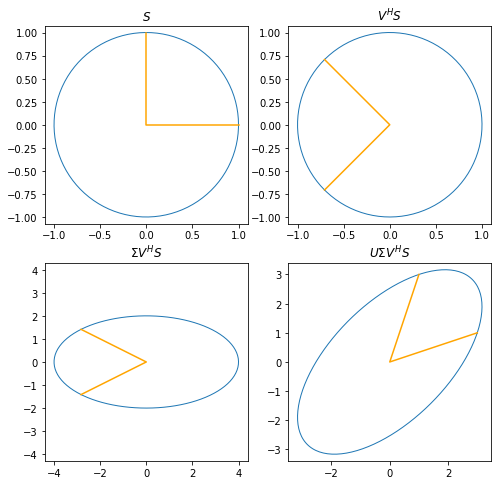

In [36]:
A = np.array([[3, 1], [1, 3]])
problem_2_SVD(A)

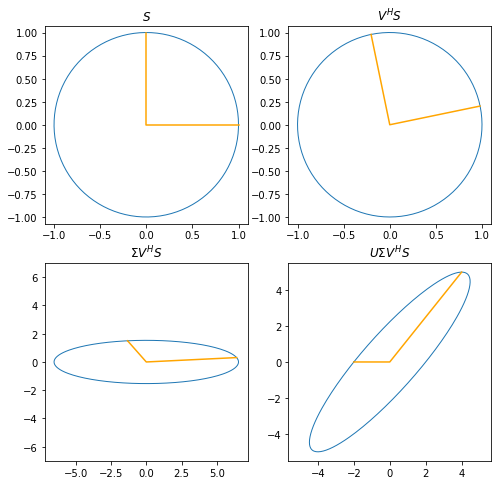

In [37]:
A = np.array([[-2, 4], [0, 5]])
problem_2_SVD(A)

### Problem 3

In [38]:
def truncated_SVD(A, s):
    U, sv, Vh = la.svd(A, full_matrices=False)

    if s > len(sv):
        raise ValueError("s is greater than the number of nonzero singular values of A.")
        
    U1 = U[:,:s]
    sv1 = sv[:s]
    Vh1 = Vh[:s,:]
    
    numEntries = np.size(U1) + np.size(sv1) + np.size(Vh1)
    
    return U1, sv1, Vh1, numEntries

In [39]:
A = np.random.random((20, 10))
U1, sv1, Vh1, numEntries = truncated_SVD(A, 5)
numEntries

155

In [40]:
np.linalg.matrix_rank(U1 @ np.diag(sv1) @ Vh1)

5

### Problem 4

In [41]:
def error_trunc_SVD(A, tol):
    U, sv, Vh = la.svd(A, full_matrices=False)
    locs1 = np.argmax(sv < tol)
    
    print(locs1)
    if tol <= sv[len(sv)-1]:
        raise ValueError("A cannot be approximated within the tolerance by a matrix of lesser rank.")
    
    U1 = U[:,:locs1]
    sv1 = sv[:locs1]
    Vh1 = Vh[:locs1, :]
    
    numEntries = np.size(U1) + np.size(sv1) + np.size(Vh1)
    
    return U1, sv1, Vh1, numEntries

In [42]:
A = np.random.random((20, 10))
U1, sv1, Vh1, numEntries = error_trunc_SVD(A, 1)
numEntries

7


217

In [43]:
np.linalg.matrix_rank(U1 @ np.diag(sv1) @ Vh1)

7

In [44]:
np.linalg.norm(A - (U1 @ np.diag(sv1) @ Vh1), ord=2)

0.9603172763719016

### Problem 5

In [45]:
def compress(filename, s):
    image = plt.imread(filename) / 255.
    orig = np.size(image)
    
    # for grayscale
    if image.ndim == 2:
        U1, sv1, Vh1, numEntries1 = truncated_SVD(image, s)
        combine = U1 @ np.diag(sv1) @ Vh1
    
    # for color 
    elif image.ndim == 3:
        R = image[:, :, 0]
        G = image[:, :, 1]
        B = image[:, :, 2]
        R1, Rsv1, RVh1, numEntriesR1 = truncated_SVD(R, s)
        G1, Gsv1, GVh1, numEntriesG1 = truncated_SVD(G, s)
        B1, Bsv1, BVh1, numEntriesB1 = truncated_SVD(B, s)
        Rapprox = R1 @ np.diag(Rsv1) @ RVh1
        Rapprox = np.clip(Rapprox, 0, 1)
        Gapprox = G1 @ np.diag(Gsv1) @ GVh1
        Gapprox = np.clip(Gapprox, 0, 1)
        Bapprox = B1 @ np.diag(Bsv1) @ BVh1
        Bapprox = np.clip(Bapprox, 0, 1)
        combine = np.dstack((Rapprox, Gapprox, Bapprox))
        numEntries1 = numEntriesR1 + numEntriesG1 + numEntriesB1
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
    if image.ndim == 3:
        ax1.imshow(image)
    elif image.ndim == 2:
        ax1.imshow(image, cmap="gray")
    ax1.axis("off")
    
    if image.ndim == 3:
        ax2.imshow(combine)
    elif image.ndim == 2:
        ax2.imshow(combine, cmap="gray")
    ax2.axis("off")
    
    plt.suptitle('Original Entries: %d, Approximation Entries: %d' %(orig, numEntries1))
    
    plt.show()
    
    #return combine

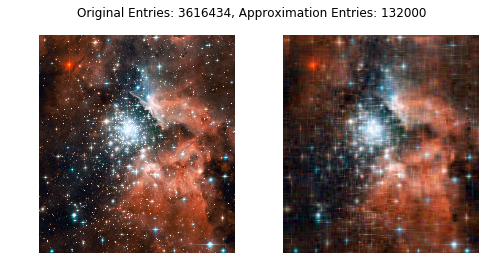

In [46]:
compress('hubble.jpg', 20)

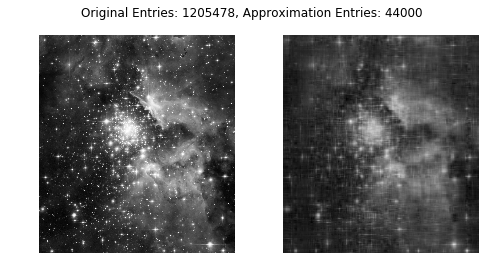

In [47]:
compress('hubble_gray.jpg', 20)

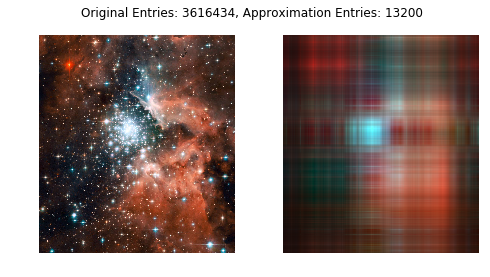

In [48]:
compress('hubble.jpg', 2)

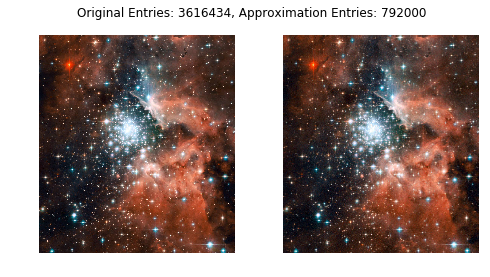

In [49]:
compress('hubble.jpg', 120)

# The Drazin Inverse

### Problem 1

In [50]:
def is_drazin(A, k, AD):
    if not np.allclose(A @ AD, AD @ A):
        return False
    elif not np.allclose(np.linalg.matrix_power(A, k+1) @ AD, np.linalg.matrix_power(A, k)):
        return False
    elif not np.allclose(AD @ A @ AD, AD):
        return False
    return True

In [51]:
A = np.array([[1,3,0,0], [0,1,3,0], [0,0,1,3], [0,0,0,0]])
AD = np.array([[1,-3,9,81], [0,1,-3,-18], [0,0,1,3], [0,0,0,0]])
B = np.array([[1,1,3], [5,2,6], [-2,-1,-3]])
BD = np.zeros((3,3))

test1 = is_drazin(A, 1, AD)
test1

True

In [52]:
test2 = is_drazin(B, 1, BD)
test2

False

In [53]:
test2 = is_drazin(B, 3, BD)
test2

True

### Problem 2

In [54]:
def drazin_inv(A, tol):
    n, n1 = np.shape(A) 
    f1 = lambda x: abs(x) > tol
    Q1,S,k1 = la.schur(A, sort=f1)
    f2 = lambda x: abs(x) <= tol
    Q2,T,k2 = la.schur(A, sort=f2)
    U = np.hstack((S[:,:k1], T[:,:(n-k1)]))
    Uinv = np.linalg.inv(U)
    V = Uinv @ A @ U
    Z = np.zeros((n,n), dtype=np.float64)
    if k1 != 0:
        Minv = np.linalg.inv(V[:k1,:k1])
        Z[:k1,:k1] = Minv
    return U @ Z @ Uinv
        

In [55]:
AD1 = drazin_inv(A, 1e-05)
test1 = is_drazin(A, 1, AD)
test1

True

In [56]:
BD1 = drazin_inv(B, 1e-05)
test2 = is_drazin(B, 3, BD1)
test2

True

### Problem 3

In [57]:
def effective_resistance(A):
    n, n1 = np.shape(A)
    L = sparse.csgraph.laplacian(A)
    R = np.zeros((n,n))
    for ii in range(n):
        for jj in range(n):
            Lj = np.copy(L)
            Lj[jj,:] = 0
            Lj[jj,jj] = 1
            LjD = drazin_inv(Lj, 1e-05)
            R[ii,jj] = LjD[ii,ii]
            if ii == jj:
                R[ii,jj] = 0
    return R

In [58]:
A1 = np.array([[0,1,0,0], [1,0,1,0], [0,1,0,1], [0,0,1,0]])
ef1 = effective_resistance(A1)
ef1

array([[0., 1., 2., 3.],
       [1., 0., 1., 2.],
       [2., 1., 0., 1.],
       [3., 2., 1., 0.]])

In [59]:
A2 = np.array([[0,1],[1,0]])
ef2 = effective_resistance(A2)
ef2[0,1]

1.0

In [60]:
A3 = np.array([[0,1,1], [1,0,1], [1,1,0]])
ef3 = effective_resistance(A3)
ef3[0,1]

0.6666666666666666

### Problem 4  and Problem 5

In [61]:
class LinkPredictor():
    
    def __init__(self, filename):
        
        connections = pd.read_csv(filename, header=None)
        
        # Construct adjacency matrix
        self.names = np.unique(np.concatenate((connections[0], connections[1])))
        N = len(self.names)
        
        adj = np.zeros((N, N))
        
        for ii in connections.index:
            name1, name2 = connections[0][ii], connections[1][ii]
            name1loc = np.where(name1 == self.names)
            name2loc = np.where(name2 == self.names)
            
            # Undirected graph
            adj[name1loc, name2loc] = 1
            adj[name2loc, name1loc] = 1
            
        self.adj = adj
        
        self.efr = effective_resistance(self.adj)
        
    def predict_link(self, node=None):
        
        # zero out entries of the effective resistance matrix whose nodes
        # are connected
        matConnect = self.efr * (1 - self.adj)
        
        # Fnd the other nde wrt "node" which have the smallest eﬀective resistance 
        # between them which are not yet connected.
        if node:
            try:
                loc = np.where(self.names == node)
            except KeyError:
                raise ValueError('Person not in social network')
        
            # extract the column where node is located
            column = matConnect[:, loc]
            minResist = np.min(column[column > 0])
            argMin = np.where(column==minResist)
            
            # Return the first instance of a minmizer
            return self.names[argMin[0]]
        
        # ﬁnd the two nodes (in the whole network) which have the smallest eﬀective resistance 
        # between them which are not yet connected.
        else:     
            # Find the other node with the minumum resistance (positive)
            minResist = np.min(matConnect[matConnect > 0])
            # Figure out where this value is
            argMin = np.where(matConnect==minResist)
            # Return the first instance of a minmizer
            return self.names[argMin[0]]     
       
    def add_link(self, node1, node2):
        try:
            loc1 = np.where(self.names == node1) 
            loc2 = np.where(self.names == node2) 
            
            # update adjacency matrix
            self.adj[loc1, loc2] = 1
            self.adj[loc2, loc1] = 1
            
            # update effective resistance matrix
            self.efr = effective_resistance(self.adj)
            
        except:
            raise ValueError('Person not in social network')


In [62]:
network = LinkPredictor('social_network.csv')
network.predict_link('Alan')

array(['Sonia'], dtype=object)

In [63]:
network.predict_link()

array(['Oliver'], dtype=object)

In [64]:
network.add_link('Alan', 'Sonia')

In [65]:
network.predict_link('Alan')

array(['Piers'], dtype=object)

In [66]:
network.add_link('Alan', 'Piers')

In [67]:
network.predict_link('Alan')

array(['Abigail'], dtype=object)

# The PageRank Algorithm

### Problem 1

In [68]:
def create_adj(filename, N):
    A = sparse.dok_matrix((N, N), dtype=np.float32)
    with open('matrix.txt', 'r') as myFile:
        try:
            for line in myFile:
                nums = line.strip().split()
                if len(nums) > 2:
                    continue
                else:
                    A[int(nums[0]), int(nums[1])] = 1
        except:
            raise ValueError('Text file error')
        finally:
            myFile.close()
    return A

In [69]:
A = create_adj('matrix.txt', 8)
print(A.toarray())

[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 1. 1. 0.]
 [1. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]


### Problem 2

In [70]:
def compute_K(A):
    # Compute the modified adjacency matrix
    for ii in range(len(A)):
        if sum(A[ii,:]) == 0:
            A[ii,:] = 1
    # Compute the diagonal matrix D
    D = np.zeros((len(A),len(A)))
    for ii in range(len(A)):
        D[ii,ii] = sum(A[ii,:])
    K = (np.linalg.inv(D) @ A).T
    return K

In [71]:
K = compute_K(A.toarray())
print(K)

[[0.         1.         0.125      0.33333333 0.33333333 0.5
  1.         1.        ]
 [0.         0.         0.125      0.         0.         0.
  0.         0.        ]
 [0.         0.         0.125      0.33333333 0.         0.
  0.         0.        ]
 [0.         0.         0.125      0.         0.         0.
  0.         0.        ]
 [0.         0.         0.125      0.         0.         0.
  0.         0.        ]
 [0.         0.         0.125      0.         0.33333333 0.
  0.         0.        ]
 [0.         0.         0.125      0.33333333 0.33333333 0.5
  0.         0.        ]
 [1.         0.         0.125      0.         0.         0.
  0.         0.        ]]


### Problem 3

In [72]:
@jit
def iterate_pr(A, N=None, d=.85, tol=1e-05):
    if N:
        A = A[:N,:N]
        pvec = np.random.random(N)
    else:
        N = len(A)
        pvec = np.random.random(N)
    K = compute_K(A)
    eps = tol + 1
    while eps > tol:
        pvecnew = d * (K @ pvec) + ((1-d)/N) * np.ones(N)
        eps = la.norm(pvecnew - pvec)
        pvec = pvecnew
    return pvec
    

In [73]:
stationary = iterate_pr(A.toarray())
stationary

array([0.43870086, 0.02171029, 0.02786154, 0.02171029, 0.02171029,
       0.02786154, 0.04585394, 0.39460113])

In [74]:
np.sum(stationary)

1.000009864948108

In [75]:
mc = qe.MarkovChain(K.T);
mc.stationary_distributions

array([[0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0.5]])

### Problem 4

In [76]:
def eigenvalue_stat(A, N=None, d=.85):
    if N:
        A = A[:N,:N]
    else:
        N = len(A)
    K = compute_K(A)
    B = d * K + ((1-d)/N) * np.ones((N,N))
    eigs, vecs = la.eig(B)
    # need to normalize the eigenvector so that it is a probability distribution
    return (vecs[:,0] / np.sum(vecs[:,0]))

In [77]:
eigenvalue_stat(A.toarray())

array([0.43869288, 0.02171029, 0.02786154, 0.02171029, 0.02171029,
       0.02786154, 0.04585394, 0.39459924])

### Problem 5

In [78]:
data = pd.read_csv('ncaa2013.csv')
win = data['WINNING_TEAM']
lose = data['LOSING_TEAM']
names = np.unique(np.concatenate((win, lose)))
N = len(names)

# Create adjacency matrix
adj = np.zeros((N, N))
for ii in data.index:
    team1, team2 = win[ii], lose[ii]
    team1ind = np.where(team1 == names)
    team2ind = np.where(team2 == names)
    adj[team2ind, team1ind] = 1
    
# Compute K matrix
#A = compute_K(adj)
# Compute SS
ss = eigenvalue_stat(adj, d=.7)

# Order teams
ranking = np.argsort(ss)
rankingOrdered = names[ranking]
print(f"The 5 best teams are: {rankingOrdered[-5:][::-1]}")

The 5 best teams are: ['Duke' 'Butler' 'Louisville' 'Illinois' 'Indiana']


# Conditioning and Stability

### Problem 1

In [79]:
def condition_mat(A):
    sv = la.svdvals(A)
    svmax = np.max(sv)
    svmin = np.min(sv)
    
    if np.abs(svmin) < 1e-5:
        conditionNum = np.inf
    else:
        conditionNum = svmax / svmin
    
    return conditionNum

In [80]:
# Singular matrices have a condition number of infinity
A = np.array([[1,0,0], [0,1,0], [0,0,0]])
cA = condition_mat(A)
cA

inf

In [81]:
# Orthonormal matrices have a condition number of 1
A = np.random.random((5,5))
Q, R = la.qr(A)
cQ = condition_mat(Q)
cQ

1.0000000000000004

In [82]:
# Compare with built-in function
A = np.random.random((5,5))
cQ1 = condition_mat(A)
cQ2 = np.linalg.cond(A)
print(cQ1, cQ2)

13.724126124201476 13.724126124201476


### Problem 2

In [83]:
def wilk():
    
    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    w_roots = np.arange(1, 21)
    w_roots = np.sort(w_roots)
      
    plt.scatter(w_roots, np.zeros(20), label='Original') 
    
    x, i = sy.symbols('x i')
    w = sy.poly_from_expr(sy.product(x-i, (i, 1, 20)))[0]
    w_coeffs = np.array(w.all_coeffs())
        
    absC = np.zeros(100)
    relC = np.zeros(100)
    
    for ii in range(100):
        mu, sigma = 1, 1e-10 # mean and standard deviation
        ri = np.random.normal(mu, sigma, 21)
        wnew = np.copy(w_coeffs) * ri
        new_roots = np.roots(np.poly1d(wnew))
        new_roots = np.sort(new_roots)
        if ii == 99:
            plt.scatter(new_roots.real, new_roots.imag, marker=',', color='black', s=1, label='Perturbed')
        else:
            plt.scatter(new_roots.real, new_roots.imag, marker=',', color='black', s=1)
    
        absC[ii] = la.norm(new_roots - w_roots, np.inf) / la.norm(wnew - w_coeffs, np.inf)
        relC[ii] = absC[ii] * la.norm(w_coeffs, np.inf) / la.norm(w_roots, np.inf)
            
    plt.legend()
    plt.xlabel('Real Axis')
    plt.ylabel('Imaginary Axis')
    plt.show()
    
    absCondition = np.mean(absC)
    relCondition = np.mean(relC)
    
    print("Absolute condition number: " + str(absCondition))
    print("Relative condition number: " + str(relCondition))

    return absCondition, relCondition 

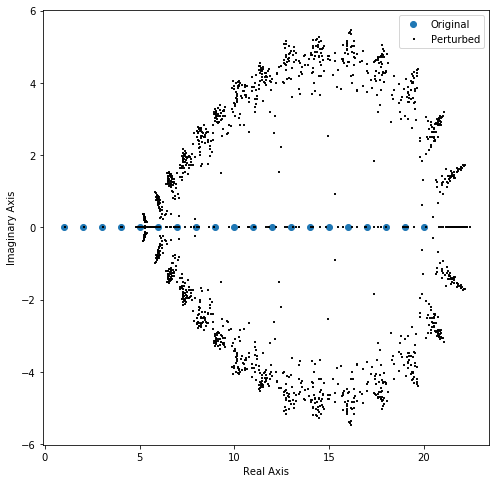

Absolute condition number: 3.3360548106799503e-09
Relative condition number: 2302504956.580168


In [84]:
absCondition, relCondition = wilk()

### Problem 3

In [85]:
def condition_eig(A):
    reals = np.random.normal(0, 1e-10, A.shape)
    imags = np.random.normal(0, 1e-10, A.shape)
    H = reals + 1j*imags
    
    eigA = la.eigvals(A)
    eigAH = la.eigvals(A + H)
    
    absC = la.norm(eigA - eigAH, 2) / la.norm(H, 2)
    relC = (la.norm(A, 2) / la.norm(eigA, 2)) * absC
    
    return absC, relC

In [86]:
A = np.random.random((10, 10))
absC, relC = condition_eig(A)
print("Absolute condition number: " + str(absC))
print("Relative condition number: " + str(relC))

Absolute condition number: 2896136473.979418
Relative condition number: 2776014837.1027393


### Problem 4

In [87]:
def condition_plot(xmin, xmax, ymin, ymax, res):
    vals = np.empty((res, res))
    x = np.linspace(xmin, xmax, res)
    y = np.linspace(ymin, ymax, res)
    for indx, xx in enumerate(x):
        for indy, yy in enumerate(y):
            vals[indx, indy] = condition_eig(np.array([[1, xx], [yy, 1]]))[1]
    
    X, Y = np.meshgrid(x, y)        
    plt.pcolormesh(X, Y, vals, cmap='gray_r')
    plt.colorbar()
    plt.show()

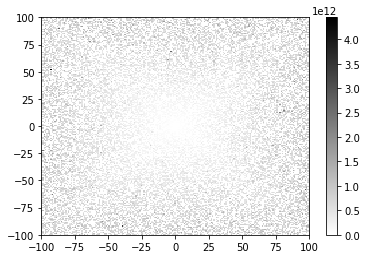

In [88]:
condition_plot(-100, 100, -100, 100, 200)

### Problem 5

In [89]:
def ls_coeff(n):
    xk, yk = np.load("stability_data.npy").T
    A = np.vander(xk, n+1)
    xinv = la.inv(A.T @ A) @ A.T @ yk
    
    Q, R = np.linalg.qr(A, mode='reduced')
    xqr = la.solve_triangular(R, Q.T @ yk)
    
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    domain = np.linspace(0, 1, 100)
    
    y1 = np.polyval(xinv, domain)
    y2 = np.polyval(xqr, domain)
    plt.scatter(xk, yk, label='Original Data', s=2, marker='*')
    plt.plot(domain, y1, 'r', label='Normal Equations')
    plt.plot(domain, y2, 'g', label='QR Solver')
    plt.title("Polynomial Approximation of Degree %i" %n)
    plt.legend()
    plt.show()
    
    forwardError1 = la.norm(A @ xinv - yk, 2)
    forwardError2 = la.norm(A @ xqr - yk, 2)
    
    print("Forward Error of Normal Equations: %d" %forwardError1)
    print("Forward Error of QR Decomposition Solution: %d" %forwardError2)
    
    return forwardError1, forwardError2

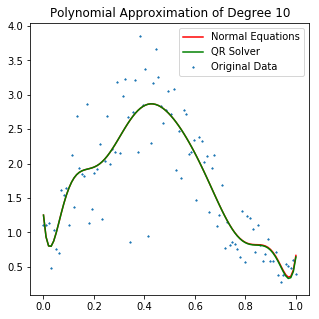

Forward Error of Normal Equations: 4
Forward Error of QR Decomposition Solution: 4


(4.6446869902282035, 4.644309587539777)

In [90]:
ls_coeff(10)

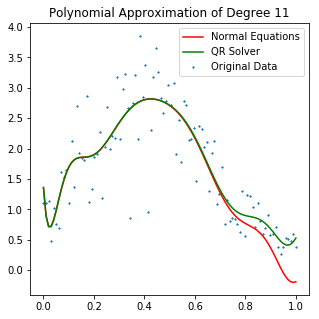

Forward Error of Normal Equations: 4
Forward Error of QR Decomposition Solution: 4


(4.973558668305269, 4.622026000822438)

In [91]:
ls_coeff(11)

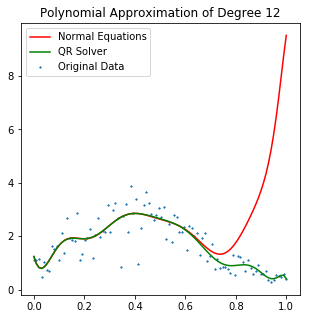

Forward Error of Normal Equations: 21
Forward Error of QR Decomposition Solution: 4


(21.105759497913752, 4.593408026935774)

In [92]:
ls_coeff(12)

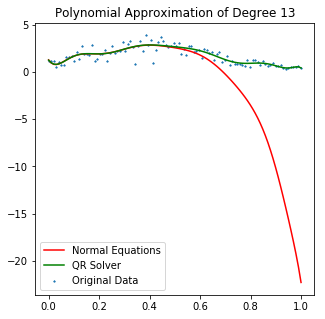

Forward Error of Normal Equations: 60
Forward Error of QR Decomposition Solution: 4


(60.508431202959514, 4.593389524004009)

In [93]:
ls_coeff(13)

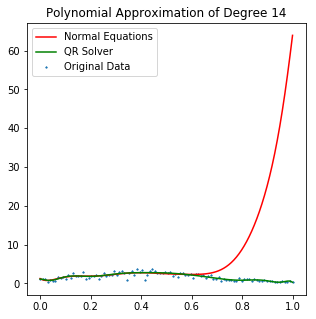

Forward Error of Normal Equations: 152
Forward Error of QR Decomposition Solution: 4


(152.14373083729365, 4.5683709383382585)

In [94]:
ls_coeff(14)

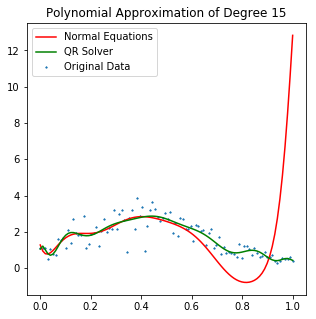

Forward Error of Normal Equations: 21
Forward Error of QR Decomposition Solution: 4


(21.495620902404788, 4.527556151558173)

In [95]:
ls_coeff(15)

### Problem 6

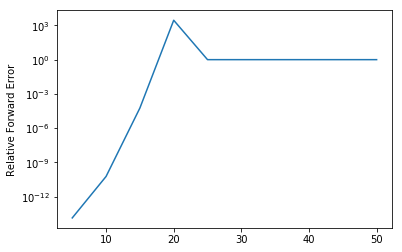

In [96]:
x = sy.Symbol('x')
err = []

for n in np.arange(5, 51, 5):
    n = int(n)
    integral =  float(sy.integrate(((x ** n) * sy.exp(x - 1)), (x,0,1)))
    sums = float(((-1) ** n) * sy.subfactorial(n) + ((-1) ** (n+1)) * (sy.factorial(n)/math.e))
    err.append(abs(sums - integral) / abs(integral))
plt.plot(np.arange(5, 51, 5), err)
plt.yscale('log')
plt.ylabel('Relative Forward Error')
plt.show()

It looks like the integral approximation is a stable way to compute $I(n)$ for large values of $n$. This may occur because of the instability of large factorials. 